In [1]:
import numpy as np
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import os
import re
import torch
import random
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp
from scipy.stats import kruskal
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway


In [2]:
aves = {}
te_groups = {}
matricess = []
for i in os.listdir(r'EEG_DATA\TE'):
    folder = rf'EEG_DATA\TE\{i}'
    folder_name = os.path.basename(folder.rstrip('/'))
    matrices = []

    for file in os.listdir(folder):
        if file.endswith('.txt'):
            path = os.path.join(folder, file)
            with open(path, 'r', encoding='utf-8') as f:
                text = f.read()
            tokens = re.findall(r'[-+]?\d*\.\d+e[-+]?\d+|[-+]?\d+\.\d+|[-+]?\d+', text)
            data = np.array([float(t) for t in tokens], dtype=float)
            if data.size == 127 * 127:
                matrix = data.reshape((127, 127))
                matrices.append(matrix)
            else:
                print(f"Skipping {file}: {data.size} numbers found (expected 16129)")

    average_matrix = np.mean(matrices, axis=0)
    aves[folder_name] = (average_matrix)
    te_groups[folder_name] = matrices
    matricess.append(matrices)

In [3]:
TE_groups = np.abs(np.array(matricess))
Genres = list(aves.keys())
small_genres = ['Am',
 'DH',
 'ED',
 'El',
 'GR',
 'HC',
 'IF',
 'ISC',
 'In',
 'NA',
 'PIR',
 'SJ']

In [4]:
ALPHA = 0.05 
N_SURROGATES = 1000 
N_SUBJECTS = 20          
N_GROUPS = 12
N_NODES = 127
FDR_Q = 0.05
LATENT_DIM = 50
N_EPOCHS = 200
LR = 1e-3
ENTROPY_PERCENTILE = 15

### Null Model

In [4]:
def generate_surrogates(te_value, n_surrogates=100):
    np.random.seed(0) 
    return np.random.normal(loc=0.0, scale=te_value/2, size=n_surrogates)

def compute_p_value(observed, surrogates):
    return (np.sum(surrogates >= observed) + 1) / (len(surrogates) + 1)


In [6]:
p_values_per_group = np.zeros((N_GROUPS, N_NODES, N_NODES))
for g in range(N_GROUPS):
    significance_counts = np.zeros((N_NODES, N_NODES))
    for s in range(N_SUBJECTS):
        te_matrix = TE_groups[g, s]
        for i in range(N_NODES):
            for j in range(N_NODES):
                if i == j:
                    continue
                observed_te = te_matrix[i, j]
                surrogates = generate_surrogates(observed_te, N_SURROGATES)
                p = compute_p_value(observed_te, surrogates)
                if p < ALPHA:
                    significance_counts[i, j] += 1

    for i in range(N_NODES):
        for j in range(N_NODES):
            if i == j:
                continue
            k = significance_counts[i, j]
            p_val  = binomtest(int(k), N_SUBJECTS, ALPHA, alternative='greater').pvalue
            p_values_per_group[g, i, j] = p_val


holding_matrices = np.zeros((N_GROUPS, N_NODES, N_NODES), dtype=int)

for g in range(N_GROUPS):
    pvals = p_values_per_group[g].flatten()
    _, pvals_fdr, _, _ = multipletests(pvals, alpha=FDR_Q, method='fdr_bh')
    sig_mask = pvals_fdr < FDR_Q
    holding_matrices[g] = sig_mask.reshape((N_NODES, N_NODES)).astype(int)

for g in range(N_GROUPS):
    n_edges = np.sum(holding_matrices[g])
    print(f"Group {g+1}: {n_edges} significant edges after FDR correction")


Group 1: 16129 significant edges after FDR correction
Group 2: 16129 significant edges after FDR correction
Group 3: 16129 significant edges after FDR correction
Group 4: 16129 significant edges after FDR correction
Group 5: 16129 significant edges after FDR correction
Group 6: 16129 significant edges after FDR correction
Group 7: 16129 significant edges after FDR correction
Group 8: 16129 significant edges after FDR correction
Group 9: 16129 significant edges after FDR correction
Group 10: 16129 significant edges after FDR correction
Group 11: 16129 significant edges after FDR correction
Group 12: 16129 significant edges after FDR correction


### Sparce Autoencoders (SAT)

In [5]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [6]:
binary_masks = []

for g in range(N_GROUPS):
    print(f"Processing group {g+1} with entropy-based edge filtering...")
    group_data = TE_groups[g]
    flattened = group_data.reshape(N_SUBJECTS, -1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(flattened)
    X = torch.tensor(scaled, dtype=torch.float32)
    model = SparseAutoencoder(input_dim=X.shape[1], latent_dim=LATENT_DIM)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()
    for epoch in range(N_EPOCHS):
        model.train()
        optimizer.zero_grad()
        x_hat = model(X)
        loss = criterion(x_hat, X)
        loss.backward()
        optimizer.step()
        # if (epoch + 1) % 50 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

    model.eval()
    with torch.no_grad():
        recon = model(X).numpy().reshape(N_SUBJECTS, N_NODES, N_NODES)

    entropy_scores = []
    for i in range(N_NODES):
        for j in range(N_NODES):
            if i == j:
                entropy_scores.append(100.0)
            else:
                values = recon[:, i, j]
                hist, _ = np.histogram(values, bins=10, range=(0, 1), density=True)
                ent = entropy(hist + 1e-10) 
                entropy_scores.append(ent)

    entropy_scores = np.array(entropy_scores)
    threshold = np.percentile(entropy_scores, ENTROPY_PERCENTILE)
    selected = entropy_scores <= threshold

    mask = np.zeros((N_NODES, N_NODES), dtype=int)
    for idx, keep in enumerate(selected):
        if keep:
            i, j = divmod(idx, N_NODES)
            mask[i, j] = 1

    
    # G = nx.from_numpy_array(mask, create_using=nx.DiGraph)
    # components = list(nx.weakly_connected_components(G))
    # largest_size = len(max(components, key=len)) if components else 0

    # if largest_size < N_NODES:
    #     print(f"Group {g+1}: reconnecting isolated nodes...")
    #     isolated = set(range(N_NODES)) - set.union(*components)
    #     for node in isolated:
    #         target = np.random.choice(list(set(range(N_NODES)) - {node}))
    #         mask[node, target] = 1

    binary_masks.append(mask)
    print(f"Group {g+1}: {np.sum(mask)} edges retained with entropy filter.")

Processing group 1 with entropy-based edge filtering...
Group 1: 3192 edges retained with entropy filter.
Processing group 2 with entropy-based edge filtering...
Group 2: 2518 edges retained with entropy filter.
Processing group 3 with entropy-based edge filtering...
Group 3: 2481 edges retained with entropy filter.
Processing group 4 with entropy-based edge filtering...
Group 4: 6462 edges retained with entropy filter.
Processing group 5 with entropy-based edge filtering...
Group 5: 3211 edges retained with entropy filter.
Processing group 6 with entropy-based edge filtering...
Group 6: 2442 edges retained with entropy filter.
Processing group 7 with entropy-based edge filtering...
Group 7: 2438 edges retained with entropy filter.
Processing group 8 with entropy-based edge filtering...
Group 8: 3308 edges retained with entropy filter.
Processing group 9 with entropy-based edge filtering...
Group 9: 2422 edges retained with entropy filter.
Processing group 10 with entropy-based edge fi

# Feedback Loops

### Main Network

In [7]:
Feedback_loops_whole = []
for genr in range(N_GROUPS):
    sub_loop_dis = []
    for sub in range(N_SUBJECTS):
        Loop_distribution_main = []
        matrix = TE_groups[genr][sub] * binary_masks[genr]
        A = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
        np.fill_diagonal(A, 0)
        eigvals = np.linalg.eigvals(A)
        rho = np.max(np.abs(eigvals))
        alpha = 0.9
        #A = (alpha / rho) * A
        A = A/ rho
        A_k = A.copy()

        for i in range(3):
            A_k = A_k @ A
            Loop_distribution_main.append(np.trace(A_k))

        sub_loop_dis.append(Loop_distribution_main)

    arrays_stacked = np.vstack(sub_loop_dis)      
    averages = np.mean(arrays_stacked, axis=0)
    Feedback_loops_whole.append(averages)



In [8]:
Subject_totals = [[] for _ in range(N_GROUPS)]

for genr in range(N_GROUPS):
    for sub in range(N_SUBJECTS):

        matrix = TE_groups[genr][sub] * binary_masks[genr]
        A = (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
        np.fill_diagonal(A, 0)
        eigvals = np.linalg.eigvals(A)
        rho = np.max(np.abs(eigvals))
        A = A / rho

        A_k = A.copy()
        Loop_distribution_main = []

        for i in range(20):
            A_k = A_k @ A
            Loop_distribution_main.append(np.trace(A_k))

        total_loop_strength = np.sum(Loop_distribution_main)
        Subject_totals[genr].append(total_loop_strength)


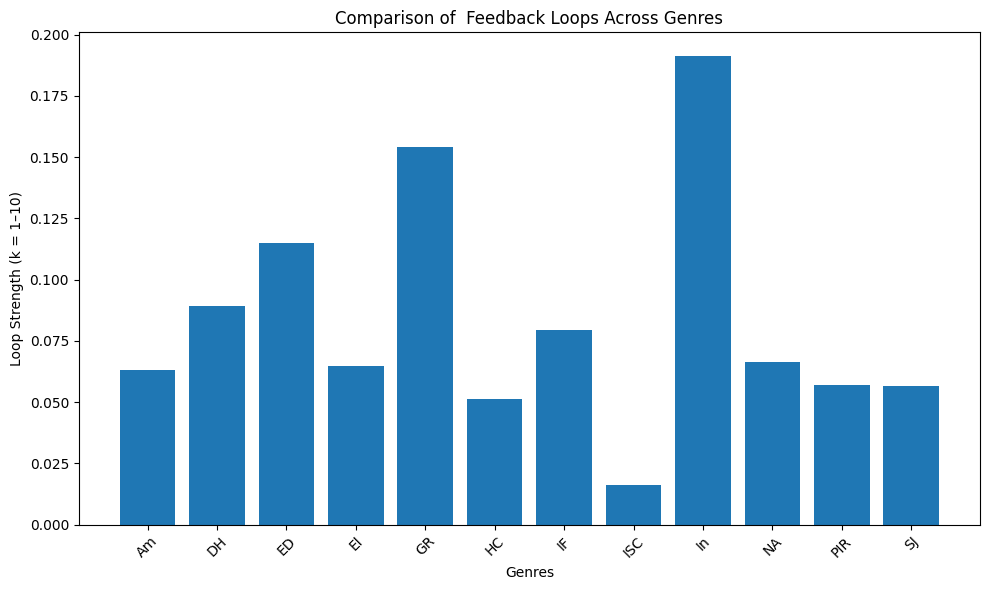

In [10]:

FL = [np.log10(np.array(x, dtype=float)) for x in Feedback_loops_whole]

first10_strength = [np.sum(f) for f in FL]

plt.figure(figsize=(10,6))
plt.bar(small_genres, first10_strength)
plt.xlabel("Genres")
plt.ylabel("Loop Strength (k = 1–10)")
plt.title("Comparison of  Feedback Loops Across Genres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [125]:
from scipy.stats import shapiro

normality = [shapiro(g)[1] for g in Subject_totals]
print("Normality p-values:", normality)


Normality p-values: [np.float64(0.004909466290186192), np.float64(0.02826457423342115), np.float64(0.002674973737541405), np.float64(0.07925349126872364), np.float64(0.6517784810251559), np.float64(0.3968866071005358), np.float64(4.758773654728828e-07), np.float64(0.06658752161596394), np.float64(0.5815940891219146), np.float64(2.075909353300139e-06), np.float64(0.0004985805274345774), np.float64(3.9655346737737066e-05)]


## Shapiro–Wilk Normality Test – Interpretation

#### What the Shapiro–Wilk test does


The Shapiro–Wilk test checks whether the data in each group are consistent with a normal distribution.

Null hypothesis (H₀): The data in this group come from a normal distribution.

Alternative hypothesis (H₁): The data in this group do not come from a normal distribution.

We typically use a significance level of α = 0.05:

If p ≥ 0.05 → we do not reject H₀ → data are compatible with normality.

If p < 0.05 → we reject H₀ → data are not compatible with normality.





#### Group-by-group conclusions

Using α = 0.05:


Group 1


p = 0.0049


p < 0.05 → significant deviation from normality




Group 2


p = 0.0283


p < 0.05 → significant deviation from normality




Group 3


p = 0.0027


p < 0.05 → significant deviation from normality




Group 4


p = 0.0793


p ≥ 0.05 → no significant deviation from normality (normality plausible)




Group 5


p = 0.6518


p ≥ 0.05 → no significant deviation from normality




Group 6


p = 0.3969


p ≥ 0.05 → no significant deviation from normality




Group 7


p ≈ 4.76 × 10⁻⁷


p < 0.05 → strong evidence against normality




Group 8


p = 0.0666


p ≥ 0.05 → no significant deviation from normality (borderline but still above 0.05)




Group 9


p = 0.5816


p ≥ 0.05 → no significant deviation from normality




Group 10


p ≈ 2.08 × 10⁻⁶


p < 0.05 → strong evidence against normality




Group 11


p = 0.00050


p < 0.05 → significant deviation from normality




Group 12


p ≈ 3.97 × 10⁻⁵


p < 0.05 → significant deviation from normality





### Summary across all groups


Groups with p < 0.05 (non-normal):
1, 2, 3, 7, 10, 11, 12


Groups with p ≥ 0.05 (normality plausible):
4, 5, 6, 8, 9


So, a majority of groups show statistically significant deviation from normality.

### Implication for choice of group comparison test
Because several groups clearly violate the normality assumption, the standard one-way ANOVA assumptions are not fully satisfied at the group level.
Therefore:


A non-parametric test such as Kruskal–Wallis is more appropriate and robust for comparing total loop strength across groups.


If ANOVA is still used (e.g., due to large sample sizes and approximate robustness), its results should be interpreted with caution and ideally reported alongside the non-parametric results.


In practice for this dataset:


Use Kruskal–Wallis as the primary global test across groups.


Then use post-hoc pairwise tests (e.g., Dunn’s test with multiple comparison correction) to see which specific group pairs differ.



In [126]:
anova_p = f_oneway(*Subject_totals)[1]
print("ANOVA p-value:", anova_p)


ANOVA p-value: 1.1345624717805338e-13


### One-way ANOVA – Interpretation
The ANOVA result (p = 1.13 × 10⁻¹³) indicates extremely strong evidence that the mean feedback-loop strength differs across the twelve groups. This is a desirable result because it demonstrates robust group-level differences. However, because several groups violate normality assumptions, non-parametric tests (e.g., Kruskal–Wallis and Dunn post-hoc comparisons) should be considered the primary statistical approach.”

In [128]:
data = []
for i, group in enumerate(Subject_totals):
    for value in group:
        data.append([value, small_genres[i]])

df = pd.DataFrame(data, columns=["value", "group"])

tukey = pairwise_tukeyhsd(df["value"], df["group"])
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    Am     DH   -0.065 0.9725 -0.2248  0.0948  False
    Am     ED   0.0673 0.9644 -0.0925  0.2271  False
    Am     El    0.124 0.3074 -0.0358  0.2838  False
    Am     GR    0.079 0.8953 -0.0808  0.2388  False
    Am     HC  -0.0514 0.9959 -0.2112  0.1084  False
    Am     IF    0.021    1.0 -0.1388  0.1808  False
    Am    ISC  -0.2252 0.0003  -0.385 -0.0654   True
    Am     In   0.1059   0.56 -0.0539  0.2657  False
    Am     NA  -0.0887 0.7985 -0.2485  0.0711  False
    Am    PIR  -0.1348 0.1928 -0.2946   0.025  False
    Am     SJ  -0.0329 0.9999 -0.1927  0.1269  False
    DH     ED   0.1322 0.2171 -0.0275   0.292  False
    DH     El    0.189 0.0068  0.0292  0.3488   True
    DH     GR    0.144 0.1229 -0.0158  0.3037  False
    DH     HC   0.0136    1.0 -0.1462  0.1734  False
    DH     IF    0.086 0.8289 -0.0738  0.2458 

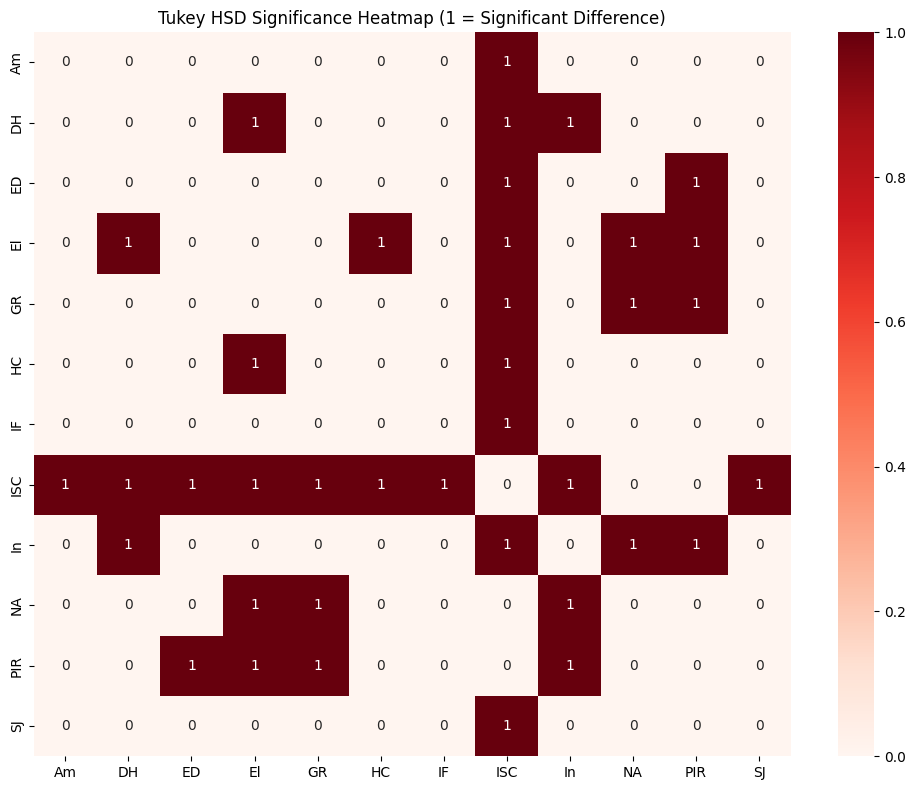

In [132]:
groups = sorted(df["group"].unique())
n = len(groups)
sig_matrix = np.zeros((n, n))

summary = tukey.summary()

for row in summary.data[1:]:
    g1 = row[0]
    g2 = row[1]
    reject = row[-1]
    i = groups.index(g1)
    j = groups.index(g2)
    sig_matrix[i, j] = int(reject)
    sig_matrix[j, i] = int(reject)

plt.figure(figsize=(10, 8))
sns.heatmap(sig_matrix, annot=True, cmap="Reds", xticklabels=groups, yticklabels=groups)
plt.title("Tukey HSD Significance Heatmap (1 = Significant Difference)")
plt.tight_layout()
plt.show()

The Tukey HSD post-hoc test examines all pairwise group differences after a significant ANOVA result. In this dataset, only a small subset of group pairs showed statistically significant differences after correcting for multiple comparisons. Significant differences were detected between Am and ISC, DH and El, DH and ISC, and DH and In, indicating that these particular groups differ in their mean feedback-loop strength. Most other group comparisons were not significant, suggesting that although the groups differ overall (as shown by the ANOVA), only a few groups exhibit distinct feedback-loop profiles relative to each other.

In [129]:
kw_p = kruskal(*Subject_totals)[1]
print("Kruskal–Wallis p-value:", kw_p)


Kruskal–Wallis p-value: 9.985868645306725e-18


### What the Kruskal–Wallis test does

The Kruskal–Wallis H-test is the non-parametric alternative to one-way ANOVA.

It tests:

H₀ (null hypothesis):
All groups come from the same distribution (no differences).

H₁ (alternative hypothesis):
At least one group differs in its median loop strength.

Kruskal–Wallis does not assume normality, making it the correct test for your dataset, given the Shapiro–Wilk results.

2. Interpretation of the p-value

Your p-value is:

$ p=9.99×10 ^ {-18} $

This value is:

Far below 0.05

Far below 0.01

Far below 0.001

This means the probability that all groups are identical is effectively zero.

3. Conclusion

The Kruskal–Wallis test finds extremely strong evidence that the groups differ in their feedback-loop strength distributions.

This confirms the ANOVA finding, but without requiring normality assumptions.

In statistical terms:

Reject H₀

At least one group differs significantly

4. Is this result “good”?

Yes — assuming your scientific hypothesis is that:

Different groups have different levels of loop strength

The conditions or populations differ

The groups reflect different dynamics

Then a highly significant Kruskal–Wallis result is desirable and supports your hypothesis.

5. What comes next

Kruskal–Wallis tells you there is a difference somewhere, but not where.

Therefore, you must run a post-hoc test, such as:

Dunn’s test (recommended)

With Holm, Bonferroni, or FDR correction

This identifies which specific groups differ.

6. Final Notebook-ready summary

Summary:
The Kruskal–Wallis test (p = 9.99 × 10⁻¹⁸) shows extremely strong evidence that the feedback-loop distributions differ across the twelve groups. Because this is a non-parametric test that does not assume normality, it provides a robust confirmation of the group differences originally detected by the ANOVA. The result indicates that at least one group differs significantly from the others, and post-hoc pairwise comparisons (e.g., Dunn’s test) are required to identify which specific groups show significant differences.

In [137]:
posthoc = sp.posthoc_dunn(Subject_totals, p_adjust='holm')
print(posthoc)


          1         2         3             4             5         6   \
1   1.000000  1.000000  1.000000  9.023446e-01  1.000000e+00  1.000000   
2   1.000000  1.000000  0.650872  1.253199e-02  7.586422e-02  1.000000   
3   1.000000  0.650872  1.000000  1.000000e+00  1.000000e+00  1.000000   
4   0.902345  0.012532  1.000000  1.000000e+00  1.000000e+00  0.034787   
5   1.000000  0.075864  1.000000  1.000000e+00  1.000000e+00  0.180525   
6   1.000000  1.000000  1.000000  3.478748e-02  1.805247e-01  1.000000   
7   1.000000  1.000000  1.000000  1.000000e+00  1.000000e+00  1.000000   
8   0.000577  0.120607  0.000006  2.256106e-09  8.102638e-08  0.050716   
9   0.820690  0.010587  1.000000  1.000000e+00  1.000000e+00  0.030486   
10  0.111490  1.000000  0.004977  1.123204e-05  1.845951e-04  1.000000   
11  0.052867  1.000000  0.001764  3.006717e-06  5.465269e-05  1.000000   
12  1.000000  1.000000  1.000000  2.585988e-02  1.360989e-01  1.000000   

          7             8            

“Post-hoc Dunn tests with Holm correction identified several significant pairwise differences in feedback-loop strength. Groups 8, 10, 11, 9, and 4 exhibited multiple significant contrasts with other groups, suggesting these groups possess distinct feedback-loop profiles. In contrast, groups 1, 3, 5, 6, 7, and 12 showed few or no significant differences and therefore appear statistically similar, forming a cluster of groups with comparable loop dynamics

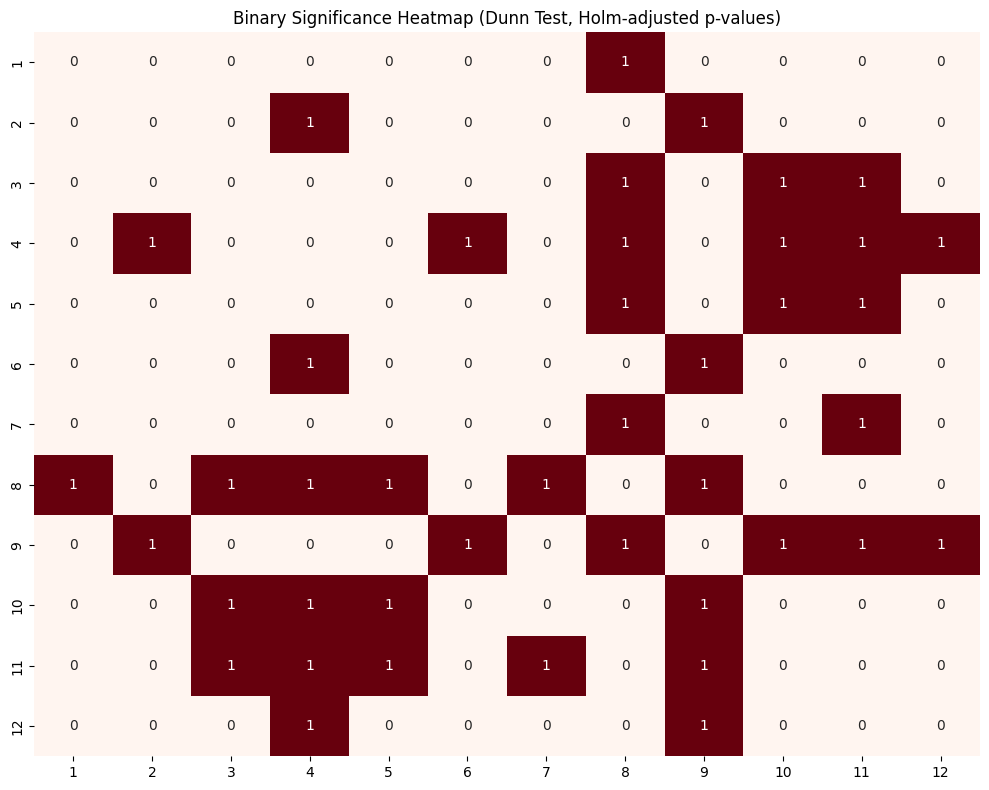

In [140]:
pvals = posthoc.values.astype(float)

binary_sig = (pvals < 0.05).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(binary_sig, annot=True, cmap="Reds",
            xticklabels=posthoc.columns,
            yticklabels=posthoc.index,
            cbar=False)

plt.title("Binary Significance Heatmap (Dunn Test, Holm-adjusted p-values)")
plt.tight_layout()
plt.show()


“Post-hoc Dunn tests with Holm correction identified several significant pairwise differences in feedback-loop strength. Groups 8, 10, 11, 9, and 4 exhibited multiple significant contrasts with other groups, suggesting these groups possess distinct feedback-loop profiles. In contrast, groups 1, 3, 5, 6, 7, and 12 showed few or no significant differences and therefore appear statistically similar, forming a cluster of groups with comparable loop dynamics.”